In [13]:
using ITensors,ITensorMPS
using RandomMeas
using ProgressBars

In [14]:
N  = 6
χ = 2^(N÷2)
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

In [15]:
NAmax = N÷2
nmax = 3
p = zeros(NAmax,nmax-1)
C3 = zeros(NAmax)
r2 = zeros(NAmax)
ITensors.disable_warn_order()
for NA in 1:NAmax
    NAB = 2*NA
    ρT,ξAB = reduce_dm(ψ,1,NAB)
    ρT = flatten(ρT)
    for i in 1:NA
        ρT  = swapind(ρT,ξAB[i],ξAB[i]')
    end
    D, U = eigen(ρT, ξAB, ξAB')
    for k in 1:nmax-1
        for s in 1:dim(D,1)
            p[NA,k] += D[s,s]^(k+1)
        end
    end
    @show NA
    C3[NA] = p[NA,1]^2/p[NA,2]
end

NA = 1
NA = 2
NA = 3


In [16]:
#Perform Randomized measurements
nu=2000
NM=100
data = zeros(Int8,(nu,NM,N))
u = Vector{Vector{ITensor}}()
for r in ProgressBar(1:nu, printing_delay=2)
    push!(u,get_rotations(ξ,1)) #Haar rotations in A
    data[r,:,:] = get_RandomMeas(ψ,u[r],NM)
end

0.0%┣                                            ┫ 0/2.0k [00:00<-2:-33, -0s/it]
16.3%┣██████▊                                  ┫ 326/2.0k [00:02<00:11, 154it/s]
91.7%┣████████████████████████████████████▊   ┫ 1.8k/2.0k [00:04<00:00, 446it/s]
100.0%┣███████████████████████████████████████┫ 2.0k/2.0k [00:04<00:00, 454it/s]
100.0%┣███████████████████████████████████████┫ 2.0k/2.0k [00:04<00:00, 454it/s]


In [17]:
C3s = zeros(NAmax)
for NA in ProgressBar(1:NAmax, printing_delay=2)
    NAB = 2*NA
    uAB = [ut[1:NAB] for ut in u]
    ξAB = ξ[1:NAB]
    #@show NA
    ρs = get_batch_shadows(data[:,:,1:NAB],ξAB,uAB,nmax)
    for n in 1:nmax
        for i in 1:NA
             ρs[n] = swapind(ρs[n],ξAB[i],ξAB[i]')
        end
    end
    p = get_moments(ρs, ξAB, nmax)
    #@show p
    C3s[NA] = p[1]^2/p[2]
end

0.0%┣                                                ┫ 0/3 [00:00<00:00, -0s/it]
100.0%┣███████████████████████████████████████████████┫ 3/3 [00:04<00:00, 2s/it]
100.0%┣███████████████████████████████████████████████┫ 3/3 [00:04<00:00, 2s/it]


In [18]:
println(C3s)

[0.9307326260309978, 1.1775778418470215, 7.420545119062847]


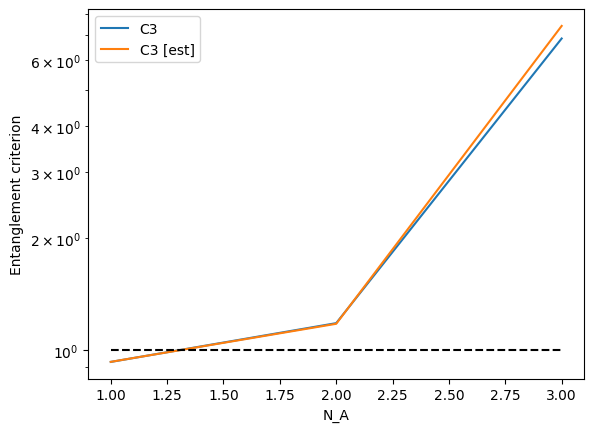

PyObject <matplotlib.legend.Legend object at 0x7f88238a12d0>

In [19]:
using PyPlot
PyPlot.plot(1:NAmax,C3,label="C3")
PyPlot.plot(1:NAmax,C3s,label="C3 [est]")
PyPlot.plot(1:NAmax,ones(NAmax),"--k")
xlabel("N_A")
yscale("log")
ylabel("Entanglement criterion")
legend()